In [232]:
from pandas import read_csv, DataFrame
from numpy.random import seed
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dense, Merge
from keras.layers.normalization import BatchNormalization
from keras import initializers, layers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import ReadStandardTimeFill as RSTF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [260]:
seed(1)

def Footprint(Input,N):
    model = Sequential()
    model.add(Dropout(0.2, input_shape = (Input.shape[1],)))
    model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(1))
    model.add(BatchNormalization())
    return(model)
    
def Weather(Input,N,BatchNorm=True):
    model = Sequential()
#     model.add(Dense(1))
    if BatchNorm == True:
        model.add(Dropout(0.2, input_shape = (Input.shape[1],)))
        model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
    else:
        model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'relu'))
    return(model)
    
def Concat(Inputs,N):
    model = Sequential()
    model.add(Merge(Inputs, mode = 'concat'))
#     model.add(Add(Inputs))#, mode = 'concat'))
#     model.add(Dense(N, activation = 'relu'))#,kernel_initializer=initializer))
#     model.add(Dropout(0.2))
#     model.add(Dense(2))
    return(model)
    
def Compile(model):
    model.add(Dense(1))
    callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model,callbacks)

class ReadStandardTimeFill:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        self.Master['fch4'] *= 1000
        self.TimeSteps=0
        
    def Scale(self,y_var,X1_vars,X2_vars=[]):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        if len(X2_vars)>0:
            X1 = self.Data[X1_vars]
            X1Standard = StandardScaler()
            self.X1Scaled= X1Standard.fit(X1)
            self.X1 = self.X1Scaled.transform(X1)
            Filling1 = self.Master[X1_vars]
            Filling1 = Filling1.interpolate().bfill()
            Filling1 = Filling1.interpolate().ffill()
            self.X1FillScaled= X1Standard.fit(Filling1)
            self.X1_fill = self.X1Scaled.transform(Filling1)
            
            X2 = self.Data[X2_vars]
            X2Standard = StandardScaler()
            self.X2Scaled= X2Standard.fit(X2)
            self.X2 = self.X2Scaled.transform(X2)
            Filling2 = self.Master[X2_vars]
            Filling2 = Filling2.interpolate().bfill()
            Filling2 = Filling2.interpolate().ffill()
            self.X2FillScaled= X2Standard.fit(Filling2)
            self.X2_fill = self.X2Scaled.transform(Filling2)
        else:
            X = self.Data[X1_vars]
            self.input_shape = len(X1_vars)
            XStandard = StandardScaler()
            self.XScaled= XStandard.fit(X)
            self.X = self.XScaled.transform(X)
            Filling = self.Master[X1_vars]
            Filling = Filling.interpolate().bfill()
            Filling = Filling.interpolate().ffill()
#             XStandard = StandardScaler()
            self.XFillScaled= XStandard.fit(Filling)
            self.X_fill = self.XScaled.transform(Filling)
        
cwd = os.getcwd()
params={}
params['Dpath'] = cwd+'/Illisarvik/'
RST = ReadStandardTimeFill(params['Dpath']+'ECData.csv')

# RST = ReadStandardTimeFill()

In [264]:
# fp_vars = ['Sedge','Grass','Shrub','Sparse','Water','Out_of_Basin']
# wx_vars = ['VWC','wind_speed', 'PPFD_Avg', 'VPD', 'AirTC_Avg','VWC','Temp']

from sklearn.model_selection import train_test_split
# fig,ax = plt.subplots(figsize=(10,10))
nCap=30#5
Score = []
Avgz=[]
ScoreB = []
AvgzB = []
# Valz = []
for i in range(2):
    seed(i)
    fp_vars = ['Sedge','Grass','Shrub','Sparse','Upland']
    wx_vars = ['wind_speed', 'PPFD_Avg', 'VPD', 'AirTC_Avg','VWC','Temp']
    RST.Scale('fco2',fp_vars,wx_vars)
    X1_train,X1_test,X2_train,X2_test,y_train,y_test=train_test_split(RST.X1,RST.X2,RST.y, test_size=0.1)
    X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1_train,X2_train,y_train, test_size=0.11)
    Fp = Footprint(X1_train,N=int(X1_train.shape[1]))#/nCap))
    Wt = Weather(X2_train,N=int(X2_train.shape[1]*2))#/nCap))
    FullModel = Concat([Fp,Wt],N=2)#int((X1_train.shape[1]+X2_train.shape[1])/(2)))#*nCap)))
    FullModel,callbacks = Compile(FullModel)
    FullModel.fit([X1_train,X2_train], y_train,
                  validation_data=([X1_test,X2_test], y_test), 
                  batch_size = 50, nb_epoch = 1000,
                  verbose = 1,callbacks=callbacks)
    Yp = FullModel.predict([X1_val,X2_val],batch_size=100)
    Avgz.append(RST.YScaled.inverse_transform(FullModel.predict([RST.X1_fill,RST.X2_fill],batch_size=100).reshape(-1,1)))
    Yp = RST.YScaled.inverse_transform(Yp.reshape(-1,1))
    Yv = RST.YScaled.inverse_transform(y_val.reshape(-1,1))
    Score.append(metrics.mean_squared_error(Yv,Yp))
    print(FullModel.count_params(),metrics.mean_squared_error(Yv,Yp))
   
    #wx_var = ['wind_speed', 'PPFD_Avg', 'VPD', 'AirTC_Avg','VWC','Temp',
#               'Sedge','Grass','Shrub','Sparse','Upland']
#     RST.Scale('fch4',fp_vars,wx_vars)
#     X1_train,X1_test,X2_train,X2_test,y_train,y_test=train_test_split(RST.X1,RST.X2,RST.y, test_size=0.1)
#     X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1_train,X2_train,y_train, test_size=0.11)
#     Wt = Weather(X2_train,N=int(X2_train.shape[0]/nCap*2),BatchNorm = False)
#     X_train = X2_train
#     X_test = X2_test
#     X_val = X2_val
#     X_fill = RST.X2_fill
#     FullModel,callbacks = Compile(Wt)
#     FullModel.fit(X_train, y_train,
#                   validation_data=(X_test, y_test), 
#                   batch_size = 50, nb_epoch = 1000,
#                   verbose = 0,callbacks=callbacks)
#     Yp = FullModel.predict(X_val,batch_size=100)
#     AvgzB.append(RST.YScaled.inverse_transform(FullModel.predict(X_fill,batch_size=100).reshape(-1,1)))
#     Yp = RST.YScaled.inverse_transform(Yp.reshape(-1,1))
#     Yv = RST.YScaled.inverse_transform(y_val.reshape(-1,1))
#     ScoreB.append(metrics.mean_squared_error(Yv,Yp))
#     print(FullModel.count_params(),metrics.mean_squared_error(Yv,Yp))

    print()
    
Avgz=np.asanyarray(Avgz).mean(axis=0)#axis=-1)
AvgzB=np.asanyarray(AvgzB).mean(axis=0)
# print(Avgz.shape)

MSE = np.asanyarray(Score)
MSEB = np.asanyarray(ScoreB)
print(MSE.mean())
print(MSEB.mean())

#old 34.37323956423951

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 754 samples, validate on 95 samples
Epoch 1/1000
754/754 [==============================] - 13s - loss: 3.7134 - val_loss: 1.7142
Epoch 2/1000
754/754 [==============================] - 0s - loss: 3.2511 - val_loss: 1.5358
Epoch 3/1000
754/754 [==============================] - 0s - loss: 2.6142 - val_loss: 1.3865
Epoch 4/1000
754/754 [==============================] - 0s - loss: 2.2521 - val_loss: 1.2695
Epoch 5/1000
754/754 [==============================] - 0s - loss: 2.0340 - val_loss: 1.1597
Epoch 6/1000
754/754 [==============================] - 0s - loss: 1.8736 - val_loss: 1.0595
Epoch 7/1000
754/754 [==============================] - 0s - loss: 1.7488 - val_loss: 0.9715
Epoch 8/1000
754/754 [==============================] - 0s - loss: 1.5316 - val_loss: 0.8858
Epoch 9/1000
754/754 [==============================] - 0s - loss: 1.3857 - val_loss: 0.8105
Epoch 10/1000
754/754 [==============================] - 0s - loss: 1.2953 - val_loss: 0.7455
Epoch 11/1000
754/754 [

754/754 [==============================] - 10s - loss: 3.8670 - val_loss: 1.1447
Epoch 2/1000
754/754 [==============================] - 0s - loss: 3.1641 - val_loss: 1.0081
Epoch 3/1000
754/754 [==============================] - 0s - loss: 2.7403 - val_loss: 0.8931
Epoch 4/1000
754/754 [==============================] - 0s - loss: 2.1529 - val_loss: 0.7952
Epoch 5/1000
754/754 [==============================] - 0s - loss: 1.8258 - val_loss: 0.7128
Epoch 6/1000
754/754 [==============================] - 0s - loss: 1.7197 - val_loss: 0.6503
Epoch 7/1000
754/754 [==============================] - 0s - loss: 1.4522 - val_loss: 0.6012
Epoch 8/1000
754/754 [==============================] - 0s - loss: 1.3653 - val_loss: 0.5516
Epoch 9/1000
754/754 [==============================] - 0s - loss: 1.2282 - val_loss: 0.5157
Epoch 10/1000
754/754 [==============================] - 0s - loss: 1.1810 - val_loss: 0.4830
Epoch 11/1000
754/754 [==============================] - 0s - loss: 1.0943 - val_

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_185 (Merge)            (None, 17)                0         
_________________________________________________________________
dense_1012 (Dense)           (None, 1)                 18        
Total params: 200
Trainable params: 166
Non-trainable params: 34
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_181 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_1011 (Dense)           (None, 12)                84        
_________________________________________________________________
dropout_182 (Dropout)        (None, 12)                0         
_________________________________________________________________
batch_

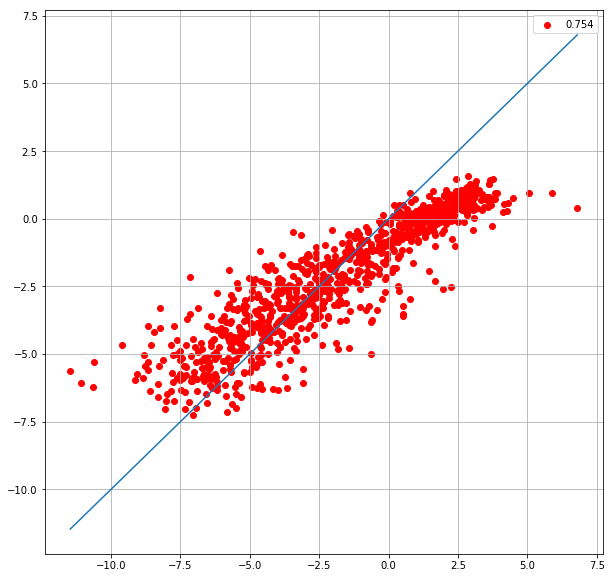

2.799


In [270]:
RST.Master['Fill'] = Avgz
RST.Master['FillB'] = AvgzB

print(FullModel.summary())
print(Wt.summary())
print(Fp.summary())

plt.figure(figsize=(10,10))
# plt.plot(Avgz[1])
Temp = RST.Master[['fco2','Fill']].dropna()#,'FillB'
plt.scatter(RST.Master['fco2'].values,Avgz,
            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['Fill']),3)),
            color='red')
# plt.scatter(RST.Master['fco2'].values,AvgzB,
#             label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['FillB']),3)),
#             color='blue')
plt.plot([Temp['fco2'].min(),Temp['fco2'].max()],[Temp['fco2'].min(),Temp['fco2'].max()])
plt.legend()

plt.grid()
plt.show()

print(np.round(metrics.mean_squared_error(Temp['fco2'],Temp['Fill']),3),)
#       np.round(metrics.mean_squared_error(Temp['fco2'],Temp['FillB']),3))

# plt.figure()
# plt.scatter(RST.Master['Sedge'],RST.Master['Fill'],s=20,label='Sedge')
# plt.scatter(RST.Master['Grass'],RST.Master['Fill'],s=20,label='Grass')
# plt.legend()
# plt.show()

# print(RST.Master.loc[np.isnan(RST.Master['Sedge'])==True,['wind_speed']])
# print(RST.Master.loc[(RST.Master.index >= '2016-07-15 12:00:00')&(RST.Master.index <= '2016-07-16 13:00:00'),
#                      ['Sedge','wind_speed']])

# plt.figure()
# plt.scatter(RST.Master['AirTC_Avg'],RST.Master['Sedge'],c=RST.Master['wind_speed'])
# plt.show()
# print(Avgz)
